In [6]:
# import statements
import itertools
from time import sleep
from kafka import KafkaProducer
import json
import random
import datetime as dt
import pandas as pd
from kafka import KafkaConsumer
import matplotlib.pyplot as plt
import statistics

## Data Visualisation using MatPlotLib

### a. Streaming data visualization:

#### i. For the incoming climate data plot the line graph of air temperature against arrival time. You need to label some interesting points such as maximum and minimum values.


<IPython.core.display.Javascript object>


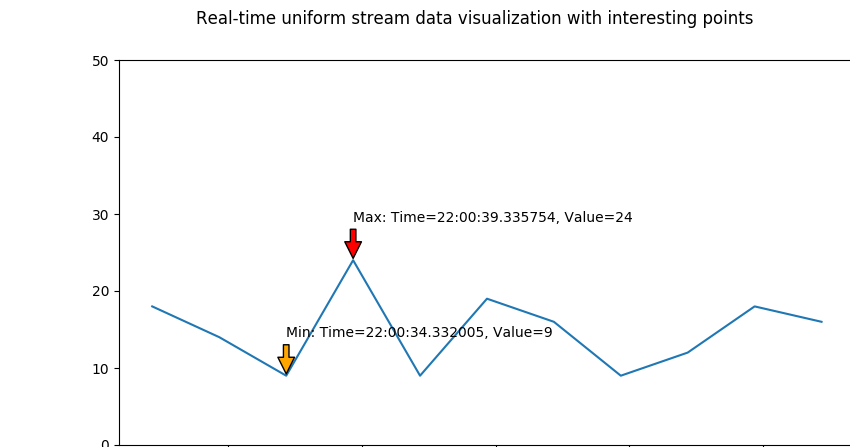

KeyboardInterrupt: 

In [7]:

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'streaming02'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 5
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,50) 
        ax.set_yticks([0,5,10,15,20,25,30,35,40,45,50])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = json.loads(message.value.decode('utf-8'))           
            
            if (data["sender_id"] == 'id_1'):
                #print(data["air_temperature_celcius"])
                #print(data["created_time"])
                t = data["created_time"]
                t2 = dt.datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f')
                t3 = t2.time()
                x.append(t3) 
                y.append(data["air_temperature_celcius"])
                
                        
            
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air Temperature Celcius')
                ax.set_ylim(0,50) 
                ax.set_yticks([0,5,10,15,20,25,30,35,40,45,50])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
                
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

### b. Static data visualization

#### i. Records with the top 10 number of fires. Plot a bar chart with time as the x-axis and number of fires as the y-axis.


In [2]:
# Import statements
import pymongo
from pymongo import MongoClient
from pprint import pprint
import collections
from collections import Counter

client = MongoClient()
db = client.FIT5148 #Connecting to the database 
coll = db.New_collection #To get collection that has the documents of data created in Task B
list1 = []
results = coll.find()

#Checking if the records have fire data (hotspot data). If it exists, then appending the firedata and 
#count for each place into a new list
for result1 in results:
    if 'hotspot_data' in result1:
        d = dict()
        l = len(result1['hotspot_data'])
        d['fire_count'] = l
        d['fire_data'] = result1['hotspot_data']
        list1.append(d)

In [3]:
#Sort the list based on the number of fires for each location in desending order and get top 10
sorted_list1 = sorted(list1, key = lambda i:i['fire_count'], reverse = True)
top10 = sorted_list1[:10]

In [4]:
#From the top 10 locations, get the time of all the fire data and put it in list l2
l2 = []
for list2 in top10:
    for j in list2['fire_data']:
        dt = j['datetime']
        splitdt = dt.split('T')
        t = splitdt[1]
        l2.append(t)

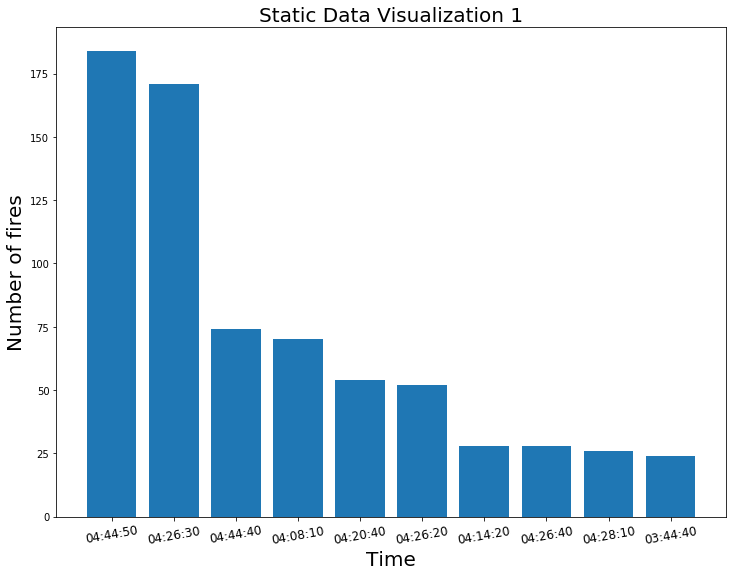

In [5]:
#Using Counter we count each unique occurrence of the time. This will give the frequency of fire against time.
count_time = Counter(l2)

# Store time and fire count in two seperate lists from top 10 fire frequency
time = [x[0] for x in count_time.most_common(10)]
fire_count = [x[1] for x in count_time.most_common(10)]

#Importing libraries to plot bar graph
import matplotlib.pyplot as plt
import numpy as np

#function to plot bar graph with time on x axis and frequency of fires on y axis
def plot_bar_graph():
    size = plt.rcParams["figure.figsize"]
    size[0] = 12
    size[1] = 9
    plt.rcParams["figure.figsize"] = size
    index = np.arange(len(time))
    plt.bar(index, fire_count)
    plt.xlabel('Time', fontsize = 20)
    plt.ylabel('Number of fires', fontsize = 20)
    plt.xticks(index, time, fontsize = 12, rotation = 10)
    plt.title('Static Data Visualization 1', fontsize = 20)
    plt.show()
    
plot_bar_graph()

#### ii. Plot fire locations in the map with air temperature, surface temperature, relative humidity and confidence. 

In [ ]:
import gmplot

# Preparing the data for plotting
hotSpotList = []

# Looping with all relevant data and make list with required information 
for i in coll.aggregate([
    {"$unwind":"$hotspot_data"},
    {"$project":{"hotspot_data.datetime":1,"air_temperature_celcius":1,
                 "hotspot_data.confidence":1, 
                 "hotspot_data.surface_temperature_celcius":1,
                 "hotspot_data.latitude":1,
                 "hotspot_data.longitude":1,
                 "relative_humidity" :1,
                 "_id":0}}    
    ]):
    
    hotSpotList.append((float(i["hotspot_data"]['latitude']), float(i["hotspot_data"]['longitude']),
                       str(i["air_temperature_celcius"]),str(i["hotspot_data"]['surface_temperature_celcius']),
                       str(i["hotspot_data"]["confidence"]),
                       str(i["relative_humidity"])))


In [ ]:
# Set map as Victoria, Australia 
gmap = gmplot.GoogleMapPlotter(-37.4713, 144.7852, 8)

#Plotting the map with mark with title. 
for i in range(len(hotSpotList)):
    text = str("Surface Temp :" + hotSpotList[i][3]
              + ", Air Temp :" + hotSpotList[i][2]
               + ", Confidence :" + hotSpotList[i][4]
               + ", Humidity :" + hotSpotList[i][5])
    #print(text)
    gmap.marker(hotSpotList[i][0], hotSpotList[i][1], "red" , title = text)

    

In [ ]:
import webbrowser
# Drawing the map
gmap.draw("firelocations.html")
webbrowser.open_new("firelocations.html")